In [1]:
## -- Set Device-Agnostic code --
import torch
print(f"ℹ️ Cuda available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    get_ipython().run_line_magic('load_ext', 'cudf.pandas')
    get_ipython().run_line_magic('load_ext', 'cuml.accel')
else:
    pass

ℹ️ Cuda available: False


In [2]:
## -- IMPORT LIBRARIES --
import sys, os, gc

## -- DATA MANIPUALATION --
import numpy as np, pandas as pd, random

## -- VISUALISATION --
from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns
import shap

## -- FUNCTIONAL TOOLS --
from itertools import combinations, product
from tqdm.notebook import tqdm
from time import time, sleep

## -- MACHINE LEARNING --
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay

if torch.cuda.is_available():
    import cuml
    from cuml.preprocessing import TargetEncoder as cuTE
else:
    from sklearn.preprocessing import TargetEncoder as sciTE

import lightgbm as lgb

import warnings

In [3]:
print(f"lightgbm version: {lgb.__version__}")
print(f"sklearn version: {sklearn.__version__}")
print(f"shap version: {shap.__version__}")

lightgbm version: 4.6.0
sklearn version: 1.7.2
shap version: 0.49.1


In [4]:
## --- GLOBAL SETTINGS --- ##
sklearn.set_config(transform_output="pandas")

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 1000)
# pd.options.mode.copy_on_write = True
# plt.style.use("whitegrid")

## -- Set Global Seed --
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

COLOR = '\033[32m'
RESET = '\033[0m'

In [5]:
## -- Load Data --
PATH = "/kaggle/input/playground-series-s5e10/"
train= pd.read_csv(PATH+"train.csv", index_col='id') #.drop('id', axis=1)
test = pd.read_csv(PATH+"test.csv", index_col='id') #.drop('id', axis=1)
submit = pd.read_csv(PATH+"sample_submission.csv")

ORIG_PATH = "/kaggle/input/simulated-roads-accident-data/"
orig = pd.concat([pd.read_csv(ORIG_PATH+"synthetic_road_accidents_100k.csv"),
                  pd.read_csv(ORIG_PATH+"synthetic_road_accidents_10k.csv"),
                  pd.read_csv(ORIG_PATH+"synthetic_road_accidents_2k.csv")],
            ignore_index=True)

TARGET = "accident_risk"
NUMS = test.select_dtypes(include='number').columns.tolist()
CATS = test.select_dtypes(exclude='number').columns.tolist()
FEATURES = NUMS + CATS

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} has shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")

Train has shape: (517754, 13)
Test has shape: (172585, 12)
Original has shape: (112000, 13)

Total Numerical: 4
Total Categorical: 8


In [6]:
train.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
id,,,,,,,,,,,,,
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [7]:
## -- Unique value counts per dataset --
TRAIN_UNIQUE = {}
ORIGINAL_UNIQUE = {}
TEST_UNIQUE = {}

for col in test.columns:
    TRAIN_UNIQUE[col] = train[col].nunique()
    ORIGINAL_UNIQUE[col] = orig[col].nunique()
    TEST_UNIQUE[col] = test[col].nunique()

unique_counts_df = pd.concat(
        [pd.DataFrame(TRAIN_UNIQUE, index=['Train']),
         pd.DataFrame(ORIGINAL_UNIQUE, index=['Original']),
         pd.DataFrame(TEST_UNIQUE, index=['Test'])],
    )

unique_counts_df.style.background_gradient(cmap='Spectral')

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
Train,3,4,261,5,3,3,2,2,3,2,2,8
Original,3,4,101,5,3,3,2,2,3,2,2,11
Test,3,4,195,5,3,3,2,2,3,2,2,8


### FEATURE ENGINEERING

In [8]:
## -- meta feature --
for df in [train, test, orig]:
    base_risk = (
        0.3 * df["curvature"] +
        0.2 * (df["lighting"] == "night").astype(int) +
        0.1 * (df["weather"] != "clear").astype(int) +
        0.2 * (df["speed_limit"] >= 60).astype(int) +
        0.1 * (np.array(df["num_reported_accidents"]) > 2).astype(int)
            )
    df['meta'] = base_risk

BINARY_COLS = [c for c in test.columns if test[c].nunique() == 2]
# for df in [train, test]:
#     df['BINARY'] = 0
#     for i in range(len(BINARY_COLS)):
#         df['BINARY'] += df[BINARY_COLS[i]].astype(int) * (2**i)

FEATURES.append('meta')
print(f"✅ 'meta' feature created!")
# print(f"✅ 'BINARY' feature created!")

✅ 'meta' feature created!


In [9]:
## -- Generate 'base_score' predictions as feature --
# from scipy.stats import norm

# def f(X):
#     return \
#     0.3 * X["curvature"] + \
#     0.2 * (X["lighting"] == "night").astype(int) + \
#     0.1 * (X["weather"] != "clear").astype(int) + \
#     0.2 * (X["speed_limit"] >= 60).astype(int) + \
#     0.1 * (X["num_reported_accidents"] > 2).astype(int)

# def clip(f):
#     def clip_f(X):
#         sigma = 0.05
#         mu = f(X)
#         a, b = -mu/sigma, (1-mu)/sigma
#         Phi_a, Phi_b = norm.cdf(a), norm.cdf(b)
#         phi_a, phi_b = norm.pdf(a), norm.pdf(b)
#         return mu*(Phi_b-Phi_a)+sigma*(phi_a-phi_b)+1-Phi_b
#     return clip_f

# for df in [train, test, orig]:
#     meta = clip(f)(df)
#     df["base_score"] = meta.values

# FEATURES.append("base_score")
# FEATURES

In [10]:
## -- FEATURE 1: Use original as features
FEAT = [c for c in orig.columns if c not in [TARGET]] # Exclude binned features
print(f"Merging {len(FEAT)} features: ", end="")
STATS = ['mean'] #,'count','nunique','max','min',
for c in FEAT:
    print(f"{c}, ", end="")
    tmp = orig.groupby(c)[TARGET].agg(STATS)
    tmp.columns = [f'OTE_{c}_{s.upper()}' for s in STATS]
    train = train.merge(tmp, on=c, how='left')
    test  = test.merge(tmp, on=c, how='left')

Merging 13 features: road_type, num_lanes, curvature, speed_limit, lighting, weather, road_signs_present, public_road, time_of_day, holiday, school_season, num_reported_accidents, meta, 

In [11]:
## -- Factorize using combined data --
for c in CATS:
    combined = pd.concat([train[c], test[c]], axis=0)
    combined = combined.factorize()[0]
    train[c] = combined[:len(train)]
    test[c]  = combined[len(train):]

print(f"✅ Label encoded {len(CATS)} features.")

✅ Label encoded 8 features.


In [12]:
BINS = []
print(f"\nCreating bins... ", end="")
for c in ['curvature', 'meta']:
    for b in [10]:
        print(f"{c}_{b}, ", end="")
        b_n = f'{c}_b{b}'
        # Fit on train data and transform both train and test
        bins = np.linspace(train[c].min(), train[c].max(), b+1)
        train[b_n] = pd.cut(train[c], include_lowest=True, labels=False, bins=bins)
        test[b_n] = pd.cut(test[c], include_lowest=True, labels=False, bins=bins)
        BINS.append(b_n)
print()
print(f"✅ {len(BINS)} binned features created!")


Creating bins... curvature_10, meta_10, 
✅ 2 binned features created!


In [13]:
# ## -- Pairwise combinations --
# # MASTER_COLS = ['curvature', 'meta']
# SLAVE_COLS  = [x for x in FEATURES if x not in ['curvature', 'meta']]
# master_slave_pairs = list(product(BINS, SLAVE_COLS))

# TE1 = []
# for c in tqdm(master_slave_pairs, desc="Creating Master-Slave Pairwise"):
#     # The order of the columns in 'c' is (master, slave)
#     c1 = c[0] # Master Column
#     c2 = c[1] # Slave Column
#     n = f'TE1_{c1}-|-{c2}'
#     train[n] = train[c1].astype(str) + '_' + train[c2].astype(str)
#     test[n]  = test[c1].astype(str)  + '_' + test[c2].astype(str)
#     train[n] = train[n].astype('category')
#     cat = train[n].cat
#     train[n] = train[n].cat.codes
#     test[n]  = pd.Categorical(test[n], categories=cat.categories).codes
#     TE1.append(n)

# print(f"✅ TE1 features: {len(TE1)}")

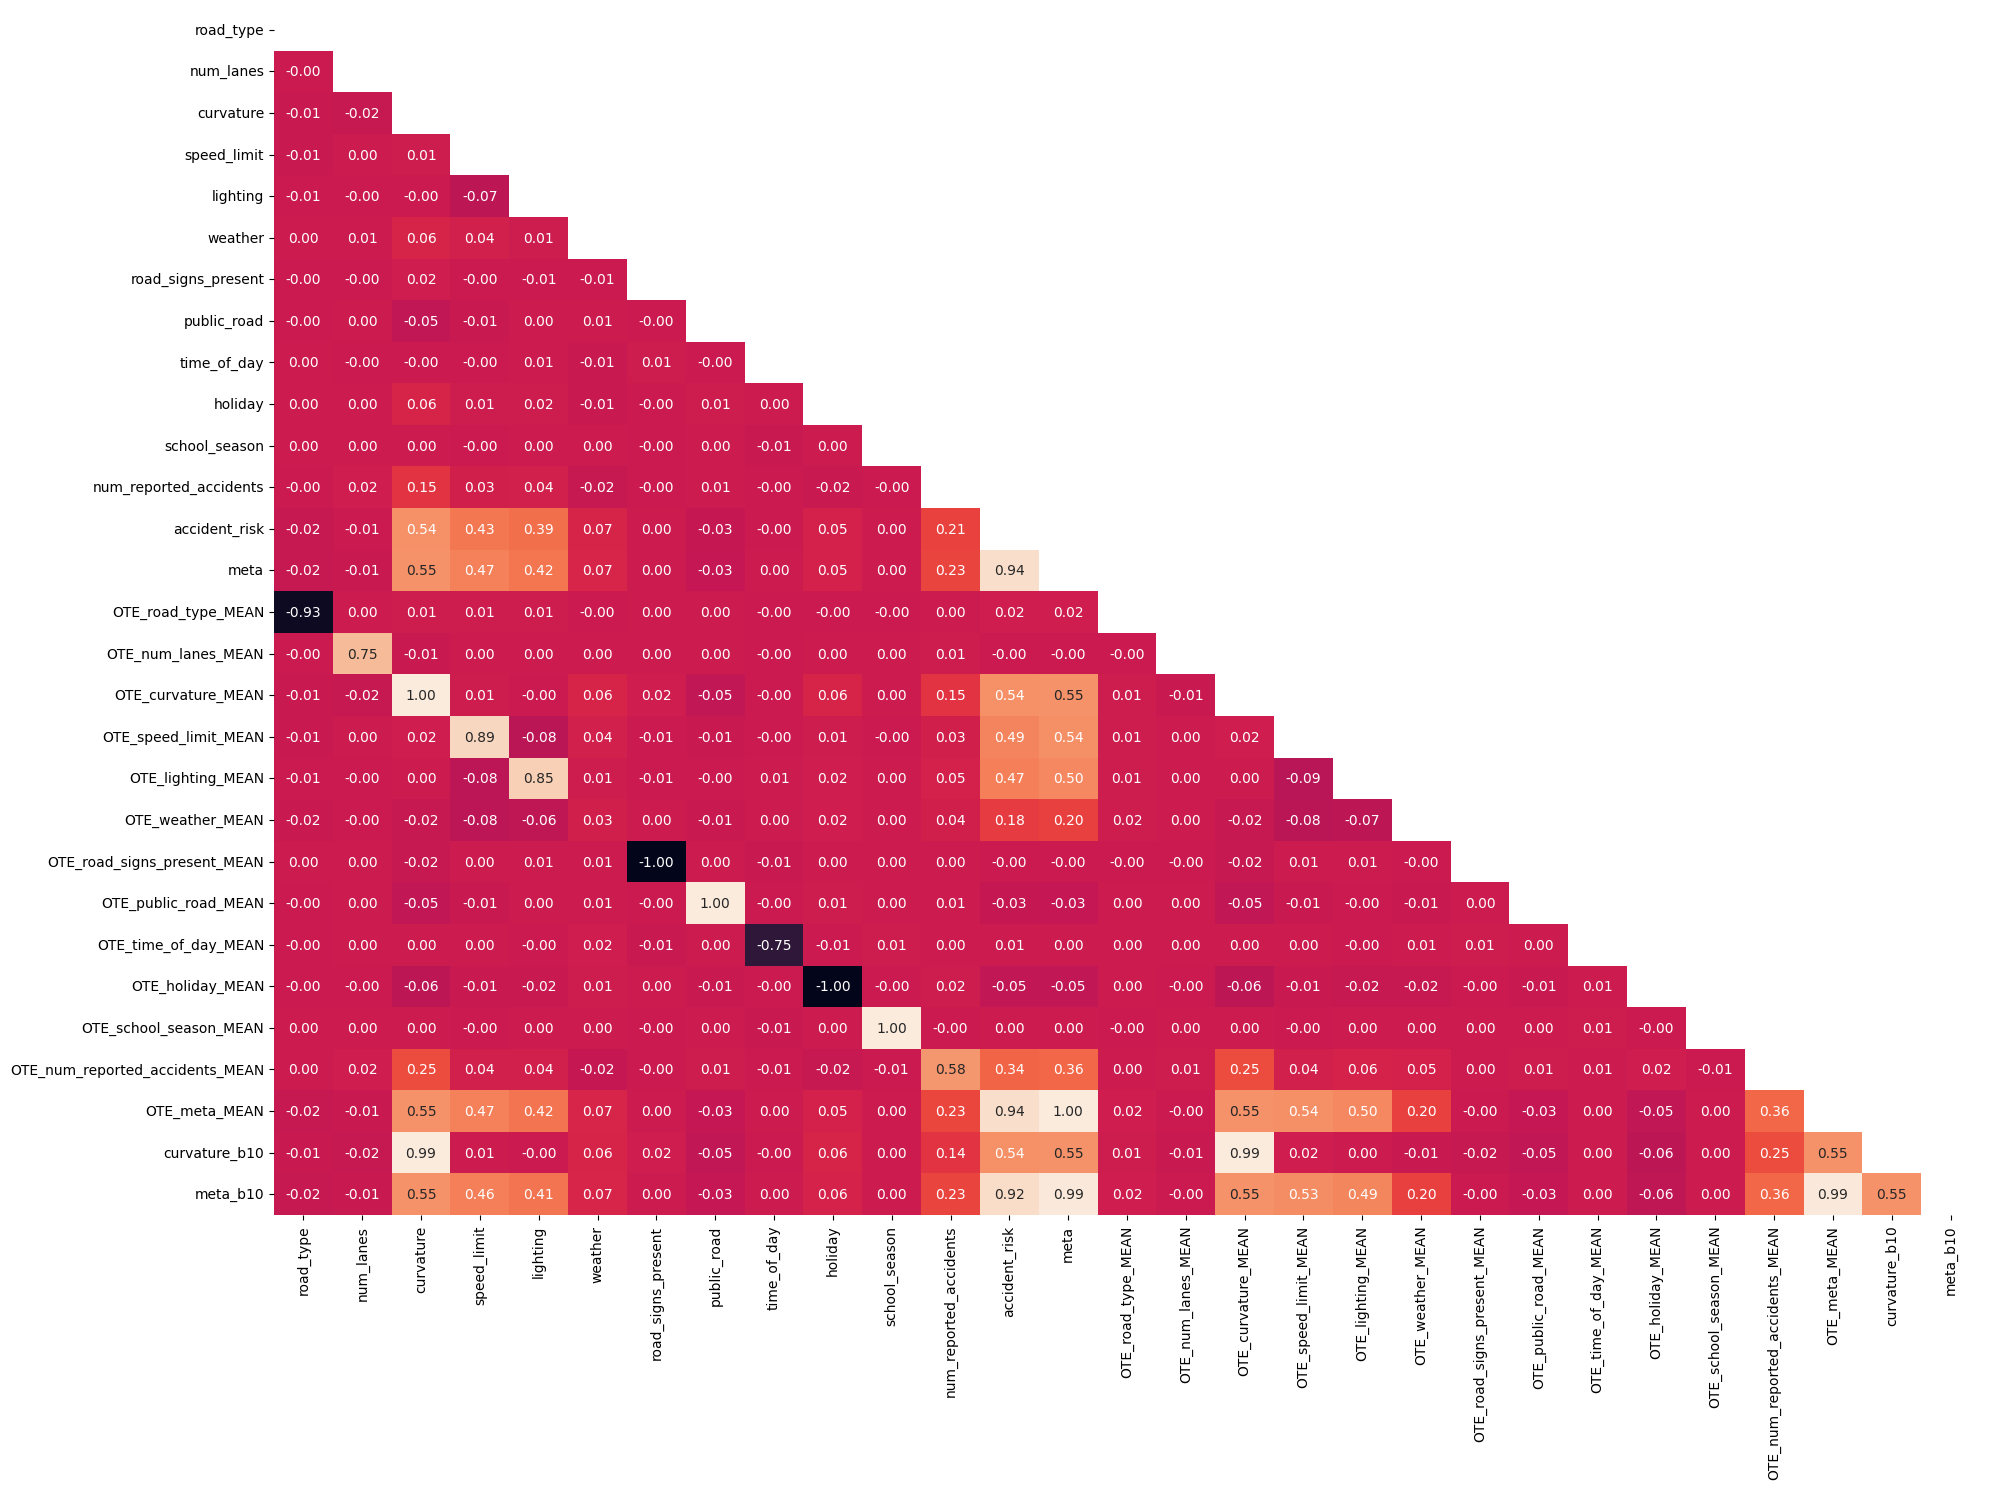

In [14]:
## -- Heatmap Plot --
plt.figure(figsize=(20, 15))
sns.heatmap(train.corr(), mask=np.triu(train.corr()), annot=True, fmt='.2f', cbar=False)
plt.tight_layout()
plt.show()

In [15]:
# -- Pairwise combinations --
TE2 = []
# COLS = [c for c in FEATURES if c not in BINARY_COLS]
for c in tqdm(list(combinations(FEATURES+BINS, 2)), desc="Creating Pairwise"):
    n = f'TE2_'+'-|-'.join(c)
    train[n] = train[c[0]].astype(str) + '_' + train[c[1]].astype(str)
    test[n]  = test[c[0]].astype(str) + '_' + test[c[1]].astype(str)
    train[n] = train[n].astype('category')
    cat = train[n].cat
    # train[n] = train[n].cat.codes
    test[n]  = pd.Categorical(test[n], categories=cat.categories)#.codes
    TE2.append(n)

Creating Pairwise:   0%|          | 0/105 [00:00<?, ?it/s]

In [16]:
## -- Triplewise combinations --
TOP_PREDICTORS = ['meta','curvature','lighting','speed_limit','weather','num_reported_accidents']
TE3 = []
for c in tqdm(list(combinations(TOP_PREDICTORS, 3)), desc="Creating Triplewise"):
    n = f'TE3_'+'-|-'.join(c)
    train[n] = train[c[0]].astype(str) + '_' + \
               train[c[1]].astype(str) + '_' + \
               train[c[2]].astype(str)
    test[n]  = test[c[0]].astype(str) + '_' + \
               test[c[1]].astype(str) + '_' + \
               test[c[2]].astype(str)

    train[n] = train[n].astype('category')
    cat = train[n].cat
    # train[n] = train[n].cat.codes
    test[n] = pd.Categorical(test[n], categories=cat.categories)#.codes
    TE3.append(n)

Creating Triplewise:   0%|          | 0/20 [00:00<?, ?it/s]

In [17]:
len(TE2), len(TE3)

(105, 20)

In [18]:
__ = [c for c in train.columns if train[c].nunique() < 2]
print(f"Produced {len(__)} single value features: {__}")
train = train.drop(__, axis=1)
test = test.drop(__, axis=1)
print(f"Drop {len(__)} columns... Complete!")

Produced 0 single value features: []
Drop 0 columns... Complete!


In [19]:
display(train.head())
# display(train.info())
train.shape, test.shape

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,meta,OTE_road_type_MEAN,OTE_num_lanes_MEAN,OTE_curvature_MEAN,OTE_speed_limit_MEAN,OTE_lighting_MEAN,OTE_weather_MEAN,OTE_road_signs_present_MEAN,OTE_public_road_MEAN,OTE_time_of_day_MEAN,OTE_holiday_MEAN,OTE_school_season_MEAN,OTE_num_reported_accidents_MEAN,OTE_meta_MEAN,curvature_b10,meta_b10,TE2_num_lanes-|-curvature,TE2_num_lanes-|-speed_limit,TE2_num_lanes-|-num_reported_accidents,TE2_num_lanes-|-road_type,TE2_num_lanes-|-lighting,TE2_num_lanes-|-weather,TE2_num_lanes-|-road_signs_present,TE2_num_lanes-|-public_road,TE2_num_lanes-|-time_of_day,TE2_num_lanes-|-holiday,TE2_num_lanes-|-school_season,TE2_num_lanes-|-meta,TE2_num_lanes-|-curvature_b10,TE2_num_lanes-|-meta_b10,TE2_curvature-|-speed_limit,TE2_curvature-|-num_reported_accidents,TE2_curvature-|-road_type,TE2_curvature-|-lighting,TE2_curvature-|-weather,TE2_curvature-|-road_signs_present,TE2_curvature-|-public_road,TE2_curvature-|-time_of_day,TE2_curvature-|-holiday,TE2_curvature-|-school_season,TE2_curvature-|-meta,TE2_curvature-|-curvature_b10,TE2_curvature-|-meta_b10,TE2_speed_limit-|-num_reported_accidents,TE2_speed_limit-|-road_type,TE2_speed_limit-|-lighting,TE2_speed_limit-|-weather,TE2_speed_limit-|-road_signs_present,TE2_speed_limit-|-public_road,TE2_speed_limit-|-time_of_day,TE2_speed_limit-|-holiday,TE2_speed_limit-|-school_season,TE2_speed_limit-|-meta,TE2_speed_limit-|-curvature_b10,TE2_speed_limit-|-meta_b10,TE2_num_reported_accidents-|-road_type,TE2_num_reported_accidents-|-lighting,TE2_num_reported_accidents-|-weather,TE2_num_reported_accidents-|-road_signs_present,TE2_num_reported_accidents-|-public_road,TE2_num_reported_accidents-|-time_of_day,TE2_num_reported_accidents-|-holiday,TE2_num_reported_accidents-|-school_season,TE2_num_reported_accidents-|-meta,TE2_num_reported_accidents-|-curvature_b10,TE2_num_reported_accidents-|-meta_b10,TE2_road_type-|-lighting,TE2_road_type-|-weather,TE2_road_type-|-road_signs_present,TE2_road_type-|-public_road,TE2_road_type-|-time_of_day,TE2_road_type-|-holiday,TE2_road_type-|-school_season,TE2_road_type-|-meta,TE2_road_type-|-curvature_b10,TE2_road_type-|-meta_b10,TE2_lighting-|-weather,TE2_lighting-|-road_signs_present,TE2_lighting-|-public_road,TE2_lighting-|-time_of_day,TE2_lighting-|-holiday,TE2_lighting-|-school_season,TE2_lighting-|-meta,TE2_lighting-|-curvature_b10,TE2_lighting-|-meta_b10,TE2_weather-|-road_signs_present,TE2_weather-|-public_road,TE2_weather-|-time_of_day,TE2_weather-|-holiday,TE2_weather-|-school_season,TE2_weather-|-meta,TE2_weather-|-curvature_b10,TE2_weather-|-meta_b10,TE2_road_signs_present-|-public_road,TE2_road_signs_present-|-time_of_day,TE2_road_signs_present-|-holiday,TE2_road_signs_present-|-school_season,TE2_road_signs_present-|-meta,TE2_road_signs_present-|-curvature_b10,TE2_road_signs_present-|-meta_b10,TE2_public_road-|-time_of_day,TE2_public_road-|-holiday,TE2_public_road-|-school_season,TE2_public_road-|-meta,TE2_public_road-|-curvature_b10,TE2_public_road-|-meta_b10,TE2_time_of_day-|-holiday,TE2_time_of_day-|-school_season,TE2_time_of_day-|-meta,TE2_time_of_day-|-curvature_b10,TE2_time_of_day-|-meta_b10,TE2_holiday-|-school_season,TE2_holiday-|-meta,TE2_holiday-|-curvature_b10,TE2_holiday-|-meta_b10,TE2_school_season-|-meta,TE2_school_season-|-curvature_b10,TE2_school_season-|-meta_b10,TE2_meta-|-curvature_b10,TE2_meta-|-meta_b10,TE2_curvature_b10-|-meta_b10,TE3_meta-|-curvature-|-lighting,TE3_meta-|-curvature-|-speed_limit,TE3_meta-|-curvature-|-weather,TE3_meta-|-curvature-|-num_reported_accidents,TE3_meta-|-lighting-|-speed_limit,TE3_meta-|-lighting-|-weather,TE3_meta-|-lighting-|-num_reported_accidents,TE3_meta-|-speed_limit-|-weather,TE3_meta-|-speed_limit-|-num_reported_accidents,TE3_meta-|-weather-|-num_reported_accidents,TE3_curvature-|-lighting-|-speed_limit,TE3_curvature-|-lighting-|-weather,TE3_curva

((517754, 154), (172585, 153))

### MODEL TRAINING

In [20]:
## -- DEFINE TRAINING PARAMETERS --
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true.values, y_pred))

params = dict( # Bagging -
    data_sample_strategy = "bagging",
    bagging_fraction = 0.8,
    feature_fraction = 0.5,
    max_depth = 7,
    max_leaves = 65,
    min_data_in_leaf = 40,
    eta = 0.005, 
    objective = "regression",
    metric = "rmse",
    verbose = -1,
    n_jobs = -1,
    device_type = "cpu",
)

# params = dict( # Goss -
#     data_sample_strategy = "goss",
#     top_rate = 0.7,
#     other_rate = 0.2,
#     max_depth = 7,
#     max_leaves = 64,
#     # min_data_in_leaf = 20,
#     eta = 0.1,
#     verbose = -1,
#     n_jobs = -1,
#     objective = "regression",
#     metric = "rmse",
#     device_type = "cpu",
# )

ℹ️ Device: CPU 4 cores
|---------------------------------
	Fold 1 #####


Target Encoding:   0%|          | 0/125 [00:00<?, ?it/s]

Training until validation scores don't improve for 300 rounds
[200]	train's rmse: 0.0804508	valid's rmse: 0.0800796
[400]	train's rmse: 0.0599143	valid's rmse: 0.059729
[600]	train's rmse: 0.0564467	valid's rmse: 0.0564481
[800]	train's rmse: 0.0558577	valid's rmse: 0.0559845
[1000]	train's rmse: 0.0556875	valid's rmse: 0.0559095
[1200]	train's rmse: 0.0555898	valid's rmse: 0.0558878
[1400]	train's rmse: 0.0555207	valid's rmse: 0.0558769
[1600]	train's rmse: 0.0554599	valid's rmse: 0.0558718
[1800]	train's rmse: 0.0554041	valid's rmse: 0.0558688
[2000]	train's rmse: 0.055345	valid's rmse: 0.0558665
[2200]	train's rmse: 0.0552866	valid's rmse: 0.0558652
[2400]	train's rmse: 0.0552302	valid's rmse: 0.0558646
[2600]	train's rmse: 0.0551754	valid's rmse: 0.0558649
Early stopping, best iteration is:
[2385]	train's rmse: 0.0552343	valid's rmse: 0.0558644
	RMSE Score: 0.055864
|---------------------------------
	Fold 2 #####


Target Encoding:   0%|          | 0/125 [00:00<?, ?it/s]

Training until validation scores don't improve for 300 rounds
[200]	train's rmse: 0.080406	valid's rmse: 0.080493
[400]	train's rmse: 0.0598317	valid's rmse: 0.0603207
[600]	train's rmse: 0.0563546	valid's rmse: 0.0570272
[800]	train's rmse: 0.0557618	valid's rmse: 0.0565415
[1000]	train's rmse: 0.0555919	valid's rmse: 0.0564559
[1200]	train's rmse: 0.0554944	valid's rmse: 0.0564302
[1400]	train's rmse: 0.0554169	valid's rmse: 0.0564193
[1600]	train's rmse: 0.0553577	valid's rmse: 0.0564155
[1800]	train's rmse: 0.0553024	valid's rmse: 0.0564134
[2000]	train's rmse: 0.0552474	valid's rmse: 0.0564114
[2200]	train's rmse: 0.0551919	valid's rmse: 0.0564094
[2400]	train's rmse: 0.0551371	valid's rmse: 0.0564068
[2600]	train's rmse: 0.0550837	valid's rmse: 0.0564045
[2800]	train's rmse: 0.0550296	valid's rmse: 0.0564029
[3000]	train's rmse: 0.0549763	valid's rmse: 0.0564019
[3200]	train's rmse: 0.054926	valid's rmse: 0.0564006
[3400]	train's rmse: 0.0548743	valid's rmse: 0.0564008
[3600]	tra

Target Encoding:   0%|          | 0/125 [00:00<?, ?it/s]

Training until validation scores don't improve for 300 rounds
[200]	train's rmse: 0.0804247	valid's rmse: 0.0803625
[400]	train's rmse: 0.0599205	valid's rmse: 0.0597605
[600]	train's rmse: 0.0564582	valid's rmse: 0.0563821
[800]	train's rmse: 0.0558679	valid's rmse: 0.0558807
[1000]	train's rmse: 0.0556977	valid's rmse: 0.055795
[1200]	train's rmse: 0.0555974	valid's rmse: 0.0557754
[1400]	train's rmse: 0.0555201	valid's rmse: 0.0557689
[1600]	train's rmse: 0.0554635	valid's rmse: 0.0557681
[1800]	train's rmse: 0.0554104	valid's rmse: 0.0557672
[2000]	train's rmse: 0.0553572	valid's rmse: 0.055767
[2200]	train's rmse: 0.0553047	valid's rmse: 0.0557665
[2400]	train's rmse: 0.0552551	valid's rmse: 0.0557664
Early stopping, best iteration is:
[2254]	train's rmse: 0.0552907	valid's rmse: 0.0557662
	RMSE Score: 0.055766
|---------------------------------
	Fold 4 #####


Target Encoding:   0%|          | 0/125 [00:00<?, ?it/s]

Training until validation scores don't improve for 300 rounds
[200]	train's rmse: 0.0804109	valid's rmse: 0.0805033
[400]	train's rmse: 0.0598782	valid's rmse: 0.0600481
[600]	train's rmse: 0.056404	valid's rmse: 0.0567154
[800]	train's rmse: 0.0558091	valid's rmse: 0.0562314
[1000]	train's rmse: 0.0556391	valid's rmse: 0.056147
[1200]	train's rmse: 0.0555422	valid's rmse: 0.0561236
[1400]	train's rmse: 0.0554591	valid's rmse: 0.0561134
[1600]	train's rmse: 0.0553957	valid's rmse: 0.0561094
[1800]	train's rmse: 0.0553386	valid's rmse: 0.0561084
[2000]	train's rmse: 0.0552821	valid's rmse: 0.0561071
[2200]	train's rmse: 0.0552263	valid's rmse: 0.0561066
[2400]	train's rmse: 0.0551699	valid's rmse: 0.0561057
[2600]	train's rmse: 0.0551132	valid's rmse: 0.056104
[2800]	train's rmse: 0.0550579	valid's rmse: 0.0561032
[3000]	train's rmse: 0.0550045	valid's rmse: 0.0561032
Early stopping, best iteration is:
[2858]	train's rmse: 0.0550421	valid's rmse: 0.0561027
	RMSE Score: 0.056103
|-------

Target Encoding:   0%|          | 0/125 [00:00<?, ?it/s]

Training until validation scores don't improve for 300 rounds
[200]	train's rmse: 0.0804341	valid's rmse: 0.0802237
[400]	train's rmse: 0.0598938	valid's rmse: 0.0598611
[600]	train's rmse: 0.0564232	valid's rmse: 0.0565564
[800]	train's rmse: 0.0558316	valid's rmse: 0.056079
[1000]	train's rmse: 0.0556628	valid's rmse: 0.0560008
[1200]	train's rmse: 0.0555695	valid's rmse: 0.0559822
[1400]	train's rmse: 0.055493	valid's rmse: 0.0559774
[1600]	train's rmse: 0.0554384	valid's rmse: 0.0559763
[1800]	train's rmse: 0.0553838	valid's rmse: 0.0559751
[2000]	train's rmse: 0.0553281	valid's rmse: 0.0559741
[2200]	train's rmse: 0.0552725	valid's rmse: 0.055973
[2400]	train's rmse: 0.0552173	valid's rmse: 0.0559729
[2600]	train's rmse: 0.0551642	valid's rmse: 0.0559739
Early stopping, best iteration is:
[2485]	train's rmse: 0.0551939	valid's rmse: 0.0559725
	RMSE Score: 0.055973
|---------------------------------
	Fold 6 #####


Target Encoding:   0%|          | 0/125 [00:00<?, ?it/s]

Training until validation scores don't improve for 300 rounds
[200]	train's rmse: 0.080417	valid's rmse: 0.0803623
[400]	train's rmse: 0.0598927	valid's rmse: 0.0598884
[600]	train's rmse: 0.0564244	valid's rmse: 0.056549
[800]	train's rmse: 0.0558344	valid's rmse: 0.0560609
[1000]	train's rmse: 0.0556664	valid's rmse: 0.0559778
[1200]	train's rmse: 0.0555711	valid's rmse: 0.0559531
[1400]	train's rmse: 0.0554907	valid's rmse: 0.0559413
[1600]	train's rmse: 0.0554272	valid's rmse: 0.0559358
[1800]	train's rmse: 0.0553708	valid's rmse: 0.0559324
[2000]	train's rmse: 0.0553151	valid's rmse: 0.05593
[2200]	train's rmse: 0.0552577	valid's rmse: 0.0559285
[2400]	train's rmse: 0.0552027	valid's rmse: 0.0559275
[2600]	train's rmse: 0.0551484	valid's rmse: 0.0559271
[2800]	train's rmse: 0.0550974	valid's rmse: 0.0559265
[3000]	train's rmse: 0.0550448	valid's rmse: 0.055926
[3200]	train's rmse: 0.0549955	valid's rmse: 0.0559263
[3400]	train's rmse: 0.0549468	valid's rmse: 0.0559266
Early stoppi

Target Encoding:   0%|          | 0/125 [00:00<?, ?it/s]

Training until validation scores don't improve for 300 rounds
[200]	train's rmse: 0.0804594	valid's rmse: 0.0800742
[400]	train's rmse: 0.0599247	valid's rmse: 0.0596728
[600]	train's rmse: 0.0564528	valid's rmse: 0.0563631
[800]	train's rmse: 0.0558599	valid's rmse: 0.0558858
[1000]	train's rmse: 0.055693	valid's rmse: 0.0558088
[1200]	train's rmse: 0.0555987	valid's rmse: 0.055787
[1400]	train's rmse: 0.055523	valid's rmse: 0.0557777
[1600]	train's rmse: 0.0554677	valid's rmse: 0.0557754
[1800]	train's rmse: 0.0554165	valid's rmse: 0.0557739
[2000]	train's rmse: 0.0553624	valid's rmse: 0.0557724
[2200]	train's rmse: 0.0553068	valid's rmse: 0.0557718
[2400]	train's rmse: 0.0552522	valid's rmse: 0.0557713
[2600]	train's rmse: 0.0551973	valid's rmse: 0.0557703
[2800]	train's rmse: 0.0551428	valid's rmse: 0.0557699
[3000]	train's rmse: 0.0550887	valid's rmse: 0.0557692
[3200]	train's rmse: 0.055036	valid's rmse: 0.0557701
Early stopping, best iteration is:
[3018]	train's rmse: 0.0550836	

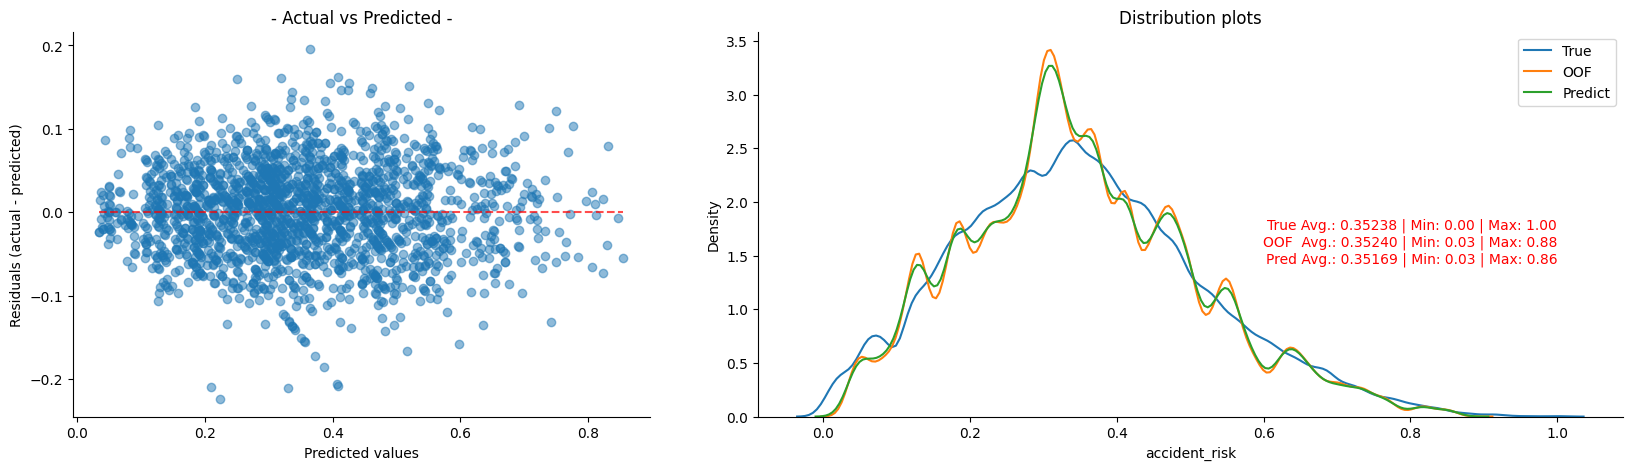

Training Time: 47.31 mins =========================


In [21]:
## -- DEFINE TRAINING PARAMETERS --
if torch.cuda.is_available():
    print(f"ℹ️ Device GPU: {torch.cuda.get_device_name(0)}")
    print(f"ℹ️ No. of CPU: {os.cpu_count()} cores")
else:
    print(f"ℹ️ Device: CPU {os.cpu_count()} cores")
## -----------------------------------------------------------
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true.values, y_pred))

oof_preds   = np.zeros(len(train))
test_preds  = np.zeros(len(test))
fold_scores = []

X = train.drop(TARGET, axis=1)
y = train[TARGET]

FOLDS = 7
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
rand_seeds = np.ceil(np.linspace(SEED, 2005, FOLDS)).astype(int)

## -- Initiate Training -- 
tik = time()
for fold, (t_idx, v_idx) in enumerate(kf.split(X)):
    print(f"|{'-'*33}")
    print(f"\t{COLOR}Fold {fold+1} {'#'*5}{RESET}")

    X_train, X_val = X.iloc[t_idx], X.iloc[v_idx]
    y_train, y_val = y.iloc[t_idx], y.iloc[v_idx]

    X_train_enc = X_train.copy()
    X_val_enc   = X_val.copy()
    test_enc    = test.copy()

    ## -- Target Encoding --
    for col in tqdm(TE2+TE3, desc="Target Encoding", leave=False):
        if torch.cuda.is_available(): # -> GPU
            TE_enc = cuTE(n_folds=5, smooth=5, split_method='random')
        else: # -> CPU
            TE_enc = sciTE(cv=5, smooth=10, random_state=SEED)
            # TE_enc = ceTE(cols=[col], smoothing=5)
        X_train_enc[col] = TE_enc.fit_transform(X_train_enc[[col]], y_train).astype('float32')
        X_val_enc[col]   = TE_enc.transform(X_val_enc[[col]]).astype('float32')
        test_enc[col]    = TE_enc.transform(test_enc[[col]]).astype('float32')

    X_train_enc[CATS] = X_train_enc[CATS].astype("category")
    X_val_enc[CATS]   = X_val_enc[CATS].astype("category")
    test_enc[CATS]    = test_enc[CATS].astype("category")

    params['seed'] = rand_seeds[fold] 

    # -- Create Pool objects --
    dtrain = lgb.Dataset(data=X_train_enc, label=y_train, categorical_feature=CATS)
    dval   = lgb.Dataset(data=X_val_enc, label=y_val, reference=dtrain, categorical_feature=CATS)
    dtest  = lgb.Dataset(data=test_enc, reference=dtrain, categorical_feature=CATS)

    model = lgb.train(
                params,
                dtrain,
                num_boost_round=20000,
                valid_sets=[dtrain, dval],
                valid_names=["train", "valid"],
                callbacks=[lgb.early_stopping(stopping_rounds=300),
                           lgb.log_evaluation(period=200)],
    )
    y_pred = model.predict(X_val_enc, num_iteration=model.best_iteration)
    oof_preds[v_idx] = np.clip(y_pred, 0, 1)
    predictions = model.predict(test_enc, num_iteration=model.best_iteration)
    test_preds += np.clip(predictions, 0, 1) / FOLDS

    ## -- Compute RMSE for validation fold --
    fold_rmse = rmse(y_val, y_pred)
    fold_scores.append(fold_rmse)
    print(f"\t{COLOR}RMSE Score: {fold_rmse:.6f}{RESET}")

    sleep(2); gc.collect(); sleep(2) # Rest. Clean. Repeat.

## -- After all folds --
overall_score = rmse(y, oof_preds)
print(f"|{'-'*50}{COLOR}")
print(f"| Total No.features: {len(X_train_enc.columns)}")
print(f"| Overall OOF  RMSE: {overall_score:.6f}")
print(f"| Average Fold RMSE: {np.mean(fold_scores):.6f} ± {np.std(fold_scores):.6f}{RESET}")

## -- Plot predictions errors --
GRID_ = dict(width_ratios=[0.4, 0.6], wspace=0.15)
fig, axs = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw=GRID_)
display = PredictionErrorDisplay.from_predictions(
                y, oof_preds, ax=axs[0], subsample=2000,
                # kind = "actual_vs_predicted",
                scatter_kwargs={"alpha": 0.5}, line_kwargs={'color': 'r'},
        )
axs[0].set_title(f"- Actual vs Predicted -")

LABELS = ['True', 'OOF', 'Predict']
sns.kdeplot(y, ax=axs[1], label=LABELS[0])
sns.kdeplot(oof_preds, ax=axs[1], label=LABELS[1])
sns.kdeplot(test_preds, ax=axs[1], label=LABELS[2])
axs[1].set_title(f"Distribution plots")
TEXT = f"""
True Avg.: {np.mean(y):.5f} | Min: {np.min(y):.2f} | Max: {np.max(y):.2f}
OOF  Avg.: {np.mean(oof_preds):.5f} | Min: {np.min(oof_preds):.2f} | Max: {np.max(oof_preds):.2f}
Pred Avg.: {np.mean(test_preds):.5f} | Min: {np.min(test_preds):.2f} | Max: {np.max(test_preds):.2f}
        """
axs[1].text(x=1, y=2, s=TEXT, ha='right', va='top', color='r')

for ax in axs:
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.legend() 
plt.tight_layout()
plt.show()

name = f"lgbBAG_" + f"{overall_score:.6f}".split('.')[1]
oof_final  = pd.DataFrame(oof_preds, columns=[name])
test_final = pd.DataFrame(test_preds, columns=[name])

tok = time()
tiktok = (tok-tik)/60
print(f"Training Time: {tiktok:.2f} mins {'='*25}")

In [22]:
X_train_enc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 443790 entries, 0 to 517753
Columns: 153 entries, road_type to TE3_speed_limit-|-weather-|-num_reported_accidents
dtypes: category(8), float32(125), float64(15), int64(5)
memory usage: 286.1 MB


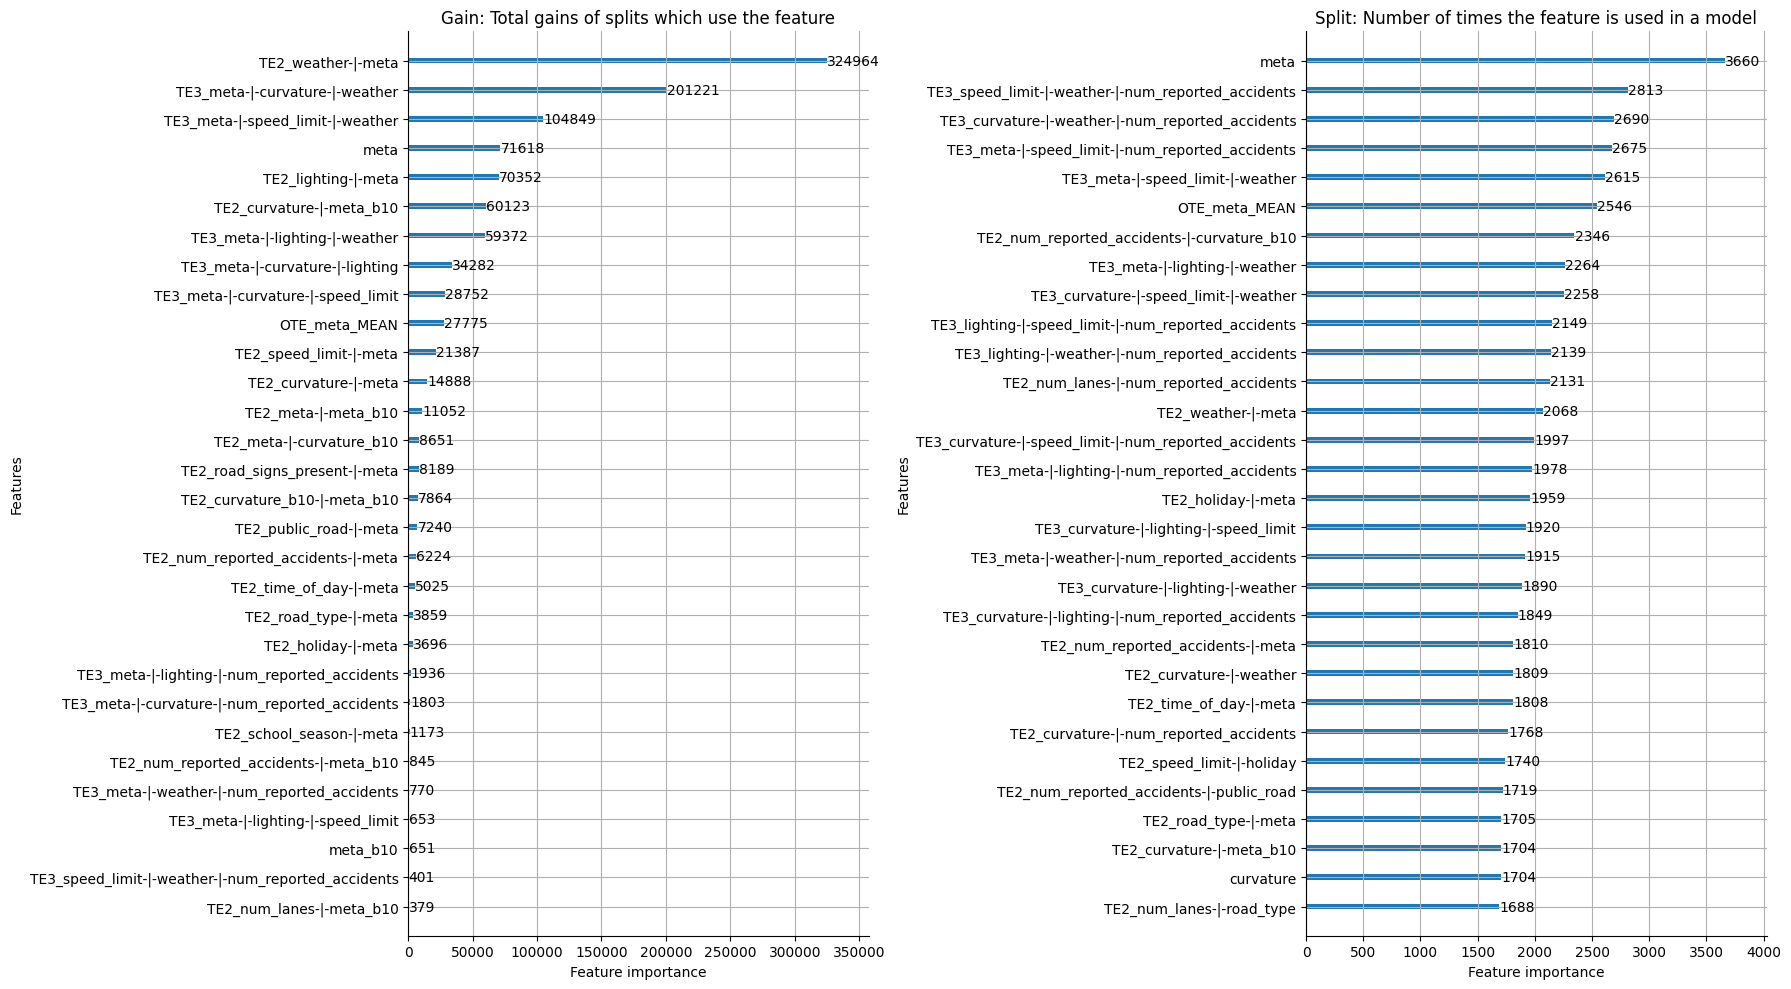

In [23]:
## -- Plot Feature Importances --
MAX = 30
_, axs = plt.subplots(1, 2, figsize=(18, 10))
lgb.plot_importance(
    model,
    ax=axs[0],
    precision = 0,
    max_num_features=MAX,
    importance_type='gain',
    title="Gain: Total gains of splits which use the feature"
)

lgb.plot_importance(
    model,
    ax=axs[1],
    precision = 0,
    max_num_features=MAX,
    importance_type='split',
    title="Split: Number of times the feature is used in a model"
)
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [24]:
model.params

{'data_sample_strategy': 'bagging',
 'bagging_fraction': 0.8,
 'feature_fraction': 0.5,
 'max_depth': 7,
 'max_leaves': 65,
 'min_data_in_leaf': 40,
 'eta': 0.005,
 'objective': 'regression',
 'metric': 'rmse',
 'verbose': -1,
 'n_jobs': -1,
 'device_type': 'cpu',
 'seed': 2005,
 'num_iterations': 20000,
 'categorical_column': [0, 4, 5, 6, 7, 8, 9, 10]}

In [25]:
## -- Save OOF & PREDICTIONS --
oof_final.to_parquet(f"{name}_oof.parquet", index=False)
test_final.to_parquet(f"{name}_pred.parquet", index=False)

## -- Submission file --
submit[TARGET] = test_final.values
submit.to_csv(f"submit_{name}.csv", index=False)
submit.head()

,id,accident_risk
0,517754,0.293649
1,517755,0.119997
2,517756,0.177982
3,517757,0.315438
4,517758,0.403372
